In [78]:
# STEP 1 -  의존성 로드 ############################################################
import numpy as np
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import seaborn as sns # seaborn ref : https://greeksharifa.github.io/machine_learning/2019/12/05/Seaborn-Module/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import statsmodels.api as sm;
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

## 정확도 지표 정의
def metrics(y_test,pred):
    print("ACC : ",accuracy_score(y_test,pred))
    print("Precision : ", precision_score(y_test,pred))
    print("recall(TP rate) : ", recall_score(y_test,pred))
    print("F1 : " , f1_score(y_test,pred))
    print("ROC SCORE : ", roc_auc_score(y_test,pred,average="macro"))


%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [79]:
## DATA LOAD
df = pd.read_csv('2018_OUTCOME.csv')
df.head()

,Unnamed: 0,age,wt_itvex,ainc,DI1_pr,DI2_pr,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_hcv,HE_HCT,HE_Uro,HE_NNAL,HE_UCREA,BM7,GS_mea_r_1,N_WAT_C,N_INTK,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_FE,N_B1,intercept
0,0,80,11065.346820,80.000000,1,1,0,162.4,82.2,21.233226,0,111,43,83,0.08,38.7,0,1.4,68.9,5,19.2,5.0,584.617278,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,4.771832,0.664332,1
1,1,78,3688.448941,1500.000000,0,0,0,167.7,98.3,27.166096,1,224,36,157,0.10,42.6,0,1.4,100.1,5,40.5,5.0,1573.428467,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,11.041512,1.175553,1
2,2,75,5244.077972,1500.000000,1,0,1,157.7,80.7,21.391845,1,165,44,101,12.06,42.3,0,1.4,105.1,5,15.3,5.0,1194.733365,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,7.348493,0.638100,1
3,3,80,5244.077972,75.666667,0,0,0,146.1,93.0,26.984977,1,160,32,229,0.06,30.2,0,1.4,67.3,2,8.6,2.5,526.064249,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,5.071129,0.877007,1
4,4,71,3315.581424,75.666667,1,0,1,157.2,78.4,21.528142,1,167,62,54,0.04,37.5,0,1.4,62.7,2,15.3,10.0,1271.085794,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,4.773000,0.646209,1


In [80]:
## SETTING DEPENDENT VAR, INDEPENDENT VARS 

Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임

In [81]:
## DO SMOTE ALG
smote = SMOTE(random_state=0)

X_train_over,Y_train_over = smote.fit_sample(X_train,Y_train)
X_test_over,Y_test_over = smote.fit_sample(X_test,Y_test)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, Y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, Y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (3308, 32) (3308,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (5732, 32) (5732,)
SMOTE 적용 후 레이블 값 분포: 
 1    2866
0    2866
Name: HE_DM, dtype: int64


0.8330592105263158
ACC :  0.8330592105263158
Precision :  0.9025844930417495
recall :  0.7467105263157895
F1 :  0.8172817281728172
ROC SCORE :  0.8330592105263157


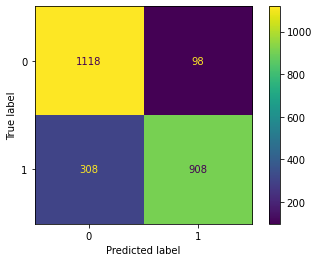

In [88]:
##PIPELINE RESAMPLED WORKFLOW
pipe = Pipeline([('scaler',StandardScaler()), ('classifiers',XGBClassifier())])
pipe.fit(X_train_over,Y_train_over)
y_preds=pipe.predict(X_test_over)
print(pipe.score(X_test_over,Y_test_over))
metrics(Y_test_over,y_preds)
plot_confusion_matrix(pipe,X_test_over,Y_test_over)

In [92]:
## K-FOLD VALIDATION 
scores = cross_val_score(estimator=pipe,
                         #X=df.drop(columns=["HE_DM"]),
                         #y=df.HE_DM,
                         X=X_test_over,
                         y=Y_test_over,
                         cv=10,
                         n_jobs=-1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.82786885 0.83196721 0.94650206 0.94238683 0.95884774 0.9218107
 0.94650206 0.94238683 0.97119342 0.94650206]
CV 정확도: 0.924 +/- 0.048
